# SDN (Scattering Delay Network) algorithm implementation

The implementation of this algorithm is part of my undergraduate degree project (a research) about (rectangular) room reverb algorithms. 
There are many research sources that were studied before performing this implementation, that is still under 
treatment. This IPython version is based on the original version that was developed on MATLAB. 

The main processing code (SDN() function) is still being revised and optimized in order to reduce coloration effect, but at this point the algorithm returns a quite decent room reverb for many source and microphone locations. 

It is important to clarify that every time the source and/or mic location (coordinates) is/are modified, every cell has to be updated in order to perceive changes.

# Required modules

In [4]:
from __future__ import division
import numpy as np
from scipy.stats import ortho_group
import scipy.linalg as la
import matplotlib.pyplot as plt
import thinkdsp
import random
from IPython.display import Audio

# Required functions

In [149]:
# Calculate delay due to distance between two points
def calcDel(p1,p2,Fs):
    cSound = 340
    return int( Fs * (np.linalg.norm(p2-p1)/cSound) )

# SDN-based reverb algorithm
def SDN(inp,sour_x,sour_y,sour_z,mic_x,mic_y,mic_z,Fs):
    # INITIAL VARIABLES
    
    # Sample rate
    Fs = 44100
    # Sound speed
    c = 340
    # Unit distance
    G = c / Fs
    # Number of nodes
    N = 6 
    # Feedback control matrix
    O_M = ortho_group.rvs(N) / 2
    # Orthonormal basis
    A = la.orth(O_M)
    # Absorption coefficients per surface
    abCoef = -np.power(np.random.rand(N),1/3)
    # Source and mic location
    sour = np.array( [sour_x,sour_y,sour_z] )
    mic = np.array( [mic_x,mic_y,mic_z] )
    # Nodes location
    rmSz = 10 # Room surfaces length
    n1 = np.array( [0,-rmSz,0] )
    n2 = np.array( [-rmSz,0,0] )
    n3 = np.array( [0,rmSz,0] )
    n4 = np.array( [rmSz,0,0] )
    n5 = np.array( [0,0,rmSz] )
    n6 = np.array( [0,0,-rmSz] )
    # Delays
    D = np.array( [ calcDel(n2,n1,Fs),calcDel(n3,n1,Fs),calcDel(n4,n1,Fs),calcDel(n5,n1,Fs),calcDel(n6,n1,Fs),\
                   calcDel(n3,n2,Fs),calcDel(n4,n2,Fs),calcDel(n5,n2,Fs),calcDel(n6,n2,Fs),calcDel(n4,n3,Fs),\
                   calcDel(n5,n3,Fs),calcDel(n6,n3,Fs),calcDel(n5,n4,Fs),calcDel(n6,n4,Fs),calcDel(n5,n6,Fs),\
                   calcDel(n1,mic,Fs),calcDel(n2,mic,Fs),calcDel(n3,mic,Fs),calcDel(n4,mic,Fs),calcDel(n5,mic,Fs),\
                   calcDel(n6,mic,Fs),calcDel(n1,sour,Fs),calcDel(n2,sour,Fs),calcDel(n3,sour,Fs),\
                   calcDel(n4,sour,Fs),calcDel(n5,sour,Fs),calcDel(n6,sour,Fs) ] )
    # Signal at each node
    x_nod_1 = np.zeros(max(D)+1)
    x_nod_2 = np.zeros(max(D)+1)
    x_nod_3 = np.zeros(max(D)+1)
    x_nod_4 = np.zeros(max(D)+1)
    x_nod_5 = np.zeros(max(D)+1)
    x_nod_6 = np.zeros(max(D)+1)
    
    # PROCESSING LOOP
    # In order to optimize cpu effort, some constants calculations are performed before the loop.
    
    # Necessary arrays
    tempArrn1 = A[0,:]*abCoef
    tempArrn2 = A[1,:]*abCoef
    tempArrn3 = A[2,:]*abCoef
    tempArrn4 = A[3,:]*abCoef
    tempArrn5 = A[4,:]*abCoef
    tempArrn6 = A[5,:]*abCoef
    # Damping coefficients
    G_n1_mic = (1/np.linalg.norm(n1-mic))
    G_n2_mic = (1/np.linalg.norm(n2-mic))
    G_n3_mic = (1/np.linalg.norm(n3-mic))
    G_n4_mic = (1/np.linalg.norm(n4-mic))
    G_n5_mic = (1/np.linalg.norm(n5-mic))
    G_n6_mic = (1/np.linalg.norm(n6-mic))
    G_s_n1 = G/np.linalg.norm(sour-n1)
    G_s_n2 = G/np.linalg.norm(sour-n2)
    G_s_n3 = G/np.linalg.norm(sour-n3)
    G_s_n4 = G/np.linalg.norm(sour-n4)
    G_s_n5 = G/np.linalg.norm(sour-n5)
    G_s_n6 = G/np.linalg.norm(sour-n6)
    G_s_m = G/np.linalg.norm(sour-mic)
    # Delays
    d_s_n1 = calcDel(sour,n1,Fs)
    d_s_n2 = calcDel(sour,n2,Fs)
    d_s_n3 = calcDel(sour,n3,Fs)
    d_s_n4 = calcDel(sour,n4,Fs)
    d_s_n5 = calcDel(sour,n5,Fs)
    d_s_n6 = calcDel(sour,n6,Fs)
    d_s_mic = calcDel(sour,mic,Fs)
    d_n2_n1 = calcDel(n2,n1,Fs)
    d_n3_n1 = calcDel(n3,n1,Fs)
    d_n4_n1 = calcDel(n4,n1,Fs)
    d_n5_n1 = calcDel(n5,n1,Fs)
    d_n6_n1 = calcDel(n6,n1,Fs)
    d_n3_n2 = calcDel(n3,n2,Fs)
    d_n4_n2 = calcDel(n4,n2,Fs)
    d_n5_n2 = calcDel(n5,n2,Fs)
    d_n6_n2 = calcDel(n6,n2,Fs)
    d_n4_n3 = calcDel(n4,n3,Fs)
    d_n5_n3 = calcDel(n5,n3,Fs)
    d_n6_n3 = calcDel(n6,n3,Fs)
    d_n5_n4 = calcDel(n5,n4,Fs)
    d_n6_n4 = calcDel(n6,n4,Fs)
    d_n6_n5 = calcDel(n6,n5,Fs)
    d_n1_mic = calcDel(n1,mic,Fs)
    d_n2_mic = calcDel(n2,mic,Fs)
    d_n3_mic = calcDel(n3,mic,Fs)
    d_n4_mic = calcDel(n4,mic,Fs)
    d_n5_mic = calcDel(n5,mic,Fs)
    d_n6_mic = calcDel(n6,mic,Fs)
    # Output initialization
    out = np.zeros( len(inp) )
    init = min(D)
    for n in range(init,len(out)):
        arr_n1 = np.array( [ I[n-d_s_n1],x_nod_2[d_n2_n1],x_nod_3[d_n3_n1],x_nod_4[d_n4_n1],x_nod_5[d_n5_n1],\
                            x_nod_6[d_n6_n1] ] )
        arr_n2 = np.array( [ x_nod_1[d_n2_n1],I[n-d_s_n2],x_nod_3[d_n3_n2],x_nod_4[d_n4_n2],x_nod_5[d_n5_n2],\
                            x_nod_6[d_n6_n2] ] )
        arr_n3 = np.array( [ x_nod_1[d_n3_n1],x_nod_2[d_n3_n2],I[n-d_s_n3],x_nod_4[d_n4_n3],x_nod_5[d_n5_n3],\
                            x_nod_6[d_n6_n3] ] )
        arr_n4 = np.array( [ x_nod_1[d_n4_n1],x_nod_2[d_n4_n2],x_nod_3[d_n4_n3],I[n-d_s_n4],x_nod_5[d_n5_n4],\
                            x_nod_6[d_n6_n4] ] )
        arr_n5 = np.array( [ x_nod_1[d_n5_n1],x_nod_2[d_n5_n2],x_nod_3[d_n5_n3],x_nod_4[d_n5_n4],I[n-d_s_n5],\
                            x_nod_6[d_n6_n5] ] )
        arr_n6 = np.array( [ x_nod_1[d_n6_n1],x_nod_2[d_n6_n2],x_nod_3[d_n6_n3],x_nod_4[d_n6_n4],x_nod_5[d_n6_n5],\
                            I[n-d_s_n6] ] )
    
        # Output obtention
        G_arr = np.array ( [ G_n1_mic,G_n2_mic,G_n3_mic,G_n4_mic,G_n5_mic,G_n6_mic,G_s_m ] )
    
        sigs = np.array( [ x_nod_1[d_n1_mic],x_nod_2[d_n2_mic],x_nod_3[d_n3_mic],x_nod_4[d_n4_mic],x_nod_5[d_n5_mic],\
                          x_nod_6[d_n6_mic],I[n-d_s_mic] ] )
    
        out[n-init] = sum( G_arr * sigs )

        # Signal at nodes (circular indexing)
        x_nod_1[0] = sum(arr_n1 * np.array( [G_s_n1,tempArrn1[1],tempArrn1[2],tempArrn1[3],tempArrn1[4],\
                                             tempArrn1[5] ] ))
        x_nod_1[1:-1] = x_nod_1[0:-2]

        x_nod_2[0] = sum(arr_n2 * np.array( [tempArrn2[0],G_s_n2,tempArrn2[2],tempArrn2[3],tempArrn2[4],\
                                             tempArrn2[5] ] ))
        x_nod_2[1:-1] = x_nod_2[0:-2]

        x_nod_3[0] = sum(arr_n3 * np.array( [tempArrn3[0],tempArrn3[1],G_s_n3,tempArrn3[3],tempArrn3[4],\
                                             tempArrn3[5] ] ))
        x_nod_3[1:-1] = x_nod_3[0:-2]

        x_nod_4[0] = sum(arr_n4 * np.array( [tempArrn4[0],tempArrn4[1],tempArrn4[2],G_s_n4,tempArrn4[4],\
                                             tempArrn4[5] ] ))
        x_nod_4[1:-1] = x_nod_4[0:-2]

        x_nod_5[0] = sum(arr_n5 * np.array( [tempArrn5[0],tempArrn5[1],tempArrn5[2],tempArrn5[3],G_s_n5,\
                                             tempArrn5[5]] ))
        x_nod_5[1:-1] = x_nod_5[0:-2]
 
        x_nod_6[0] = sum(arr_n6 * np.array( [tempArrn6[0],tempArrn6[1],tempArrn6[2],tempArrn6[3],\
                                             tempArrn6[4],G_s_n6] ))
        x_nod_6[1:-1] = x_nod_6[0:-2]

    # Normalize output
    out = out / np.abs(max(out))
    return out

# Get the IR

In [155]:
# Read an audio signal
audio = thinkdsp.read_wave(filename='ElecGtr.wav')
# Impulse as the system input
I = np.zeros(20000)
I[0] = 1
# Get the IR
(sour_x,sour_y,sour_z) = (-2,0,0)
(mic_x,mic_y,mic_z) = (1,5,-6)
IR = SDN(I,sour_x,sour_y,sour_z,mic_x,mic_y,mic_z,audio.framerate)

# Plot the IR

Text(0.5,1,'Rm_sze: 10,10,10. sour:[-2.00,0.00,0.00], mic:[1.00,5.00,-6.00]')

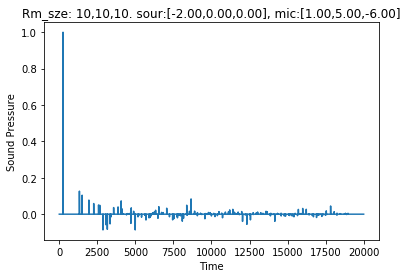

In [156]:
fig,ax = plt.subplots()
ax.plot( IR )
ax.set_xlabel('Time')
ax.set_ylabel('Sound Pressure')
ax.set_title( 'Rm_sze: 10,10,10. sour:[%1.2f,%1.2f,%1.2f], mic:[%1.2f,%1.2f,%1.2f]'\
             %(sour_x,sour_y,sour_z,mic_x,mic_y,mic_z) )

# Plot the IR spectrum

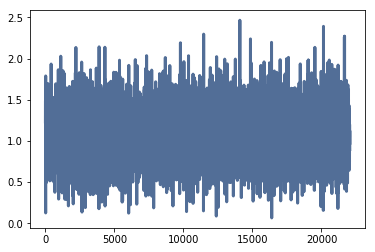

In [157]:
# Get the IR spectrum
IR_spectrum = thinkdsp.Wave(ys=IR,framerate=audio.framerate).make_spectrum()
IR_spectrum.plot()

# Process the audio signal

In [158]:
# Audio signal length
L = len(audio.ys)
# IR length
N = len(IR)
M = L + N - 1
# Convolution process (freq domain). Extract the real part
wetSig = np.fft.ifft( (np.fft.fft(audio.ys,M)*np.fft.fft(IR,M)) ).real
# Transform into a wave object
wS = thinkdsp.Wave(ys=wetSig,framerate=audio.framerate)
# Optimize signal
wS.make_audio()
wS.normalize()
wS.apodize()

# Listen to the signals

In [84]:
# Original signal
Audio(data=audio.ys,rate=audio.framerate)

In [159]:
# Processed signal
Audio(data=wS.ys,rate=audio.framerate)